# 잡음 제거 테스트

노이즈 제거하지 않은 버전

In [5]:
import speech_recognition as sr
import wave
import io
import noisereduce as nr

# 오디오 데이터를 wav 파일로 저장하는 함수
def save_buffer_to_wav(buffer, sample_rate, sample_width, filename):
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)  # 모노
        wf.setsampwidth(sample_width)
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(buffer))

# 마이크에서 음성을 스트리밍하는 함수
def record_audio(filename="output.wav"):
    recognizer = sr.Recognizer()
    microphone = sr.Microphone(sample_rate=16000)
    buffer = []
    chunk_size = 16000
    num_chunks = 5

    with microphone as source:
        print("Adjusting for ambient noise..."); recognizer.adjust_for_ambient_noise(source)  # 주변 소음을 기준으로 에너지 임계값 조정
        
        print("Recording...")
        recognizer.energy_threshold = recognizer.energy_threshold + 100

        while len(buffer) < num_chunks:
            buffer.append(source.stream.read(chunk_size))

    sample_rate = microphone.SAMPLE_RATE
    sample_width = microphone.SAMPLE_WIDTH
    save_buffer_to_wav(buffer, sample_rate, sample_width, filename)
    print("Audio saved to {}".format(filename))

if __name__ == "__main__":
    record_audio()


Adjusting for ambient noise...
Recording...


KeyboardInterrupt: 

노이즈 제거 기법 2개 넣음: 엄청 잘 됨

In [ ]:
'''
240620 sk 사물인식 건으로 음성인식 업무 보류.
noisereduce 라이브러리 이용해서 노이즈 감소시키는 테스트 해보려고 함.
아래 코드는 chatgpt가 마지막으로 만들어준 코드
바로 위 코드에다가 노이즈 감소 코드를 추가했고 아직 실행은 안해봄
'''

import speech_recognition as sr
import wave
import noisereduce as nr
import numpy as np

# 오디오 데이터를 wav 파일로 저장하는 함수
def save_buffer_to_wav(buffer, sample_rate, sample_width, filename):
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)  # 모노
        wf.setsampwidth(sample_width)
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(buffer))

# 마이크에서 음성을 스트리밍하는 함수
def record_audio(filename="output.wav"):
    chunk_size = 1024
    recognizer = sr.Recognizer()
    microphone = sr.Microphone(sample_rate=16000, chunk_size=chunk_size)
    buffer = []
    num_chunks = int(5 * microphone.SAMPLE_RATE / chunk_size)

    with microphone as source:
        print("Adjusting for ambient noise...")
        recognizer.adjust_for_ambient_noise(source)  # 주변 소음을 기준으로 에너지 임계값 조정

        print("Recording...")
        recognizer.energy_threshold += 100

        while len(buffer) < num_chunks:
            buffer.append(source.stream.read(chunk_size))

    # 버퍼를 하나의 오디오 데이터로 결합
    audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
    # 노이즈 감소
    reduced_noise = nr.reduce_noise(y=audio_data,
                                    sr=microphone.SAMPLE_RATE,
                                    prop_decrease=0.0)
    '''
    [reduce_noise 기본값 및 인수 설명]
    y=, # 입력 신호 (numpy 배열 형태).
    sr=, # 입력 신호의 샘플링 레이트.
    stationary=False, # 정적 노이즈 감소를 수행할지 여부 (기본값: False).
    y_noise=None, # 노이즈 신호 (정적 노이즈 감소 시 통계 계산용).
    prop_decrease=1.0, # 노이즈 감소 비율 (기본값: 1.0, 100%).
    time_constant_s=2.0, # 비정적 노이즈 감소 시 노이즈 플로어 계산 시간 상수 (초 단위, 기본값: 2.0).
    freq_mask_smooth_hz=500, # 마스크를 주파수 범위에서 평활화 (Hz 단위, 기본값: 500).
    time_mask_smooth_ms=50, # 마스크를 시간 범위에서 평활화 (밀리초 단위, 기본값: 50).
    thresh_n_mult_nonstationary=2, # 비정적 노이즈 감소 시 임계값 배수 (기본값: 2).
    sigmoid_slope_nonstationary=10, # 비정적 노이즈 감소 시 시그모이드 기울기 (기본값: 10).
    n_std_thresh_stationary=1.5, # 정적 노이즈 감소 시 평균 위의 표준 편차 수 (기본값: 1.5).
    tmp_folder=None, # 병렬 처리 시 임시 폴더 (기본값: None).
    chunk_size=600000, # 신호 청크 크기 (기본값: 600000).
    padding=30000, # 각 신호 청크를 패딩하는 크기 (기본값: 30000).
    n_fft=1024, # FFT 윈도우 길이 (기본값: 1024).
    win_length=None, # 윈도우 길이 (기본값: n_fft와 동일).
    hop_length=None, # 인접 STFT 열 간의 오디오 샘플 수 (기본값: win_length // 4).
    clip_noise_stationary=True, # 정적 노이즈 감소 시 노이즈 클립 여부 (기본값: True).
    use_tqdm=False, # 진행률 표시줄 표시 여부 (기본값: False).
    n_jobs=1, # 병렬 작업 수 (기본값: 1).
    use_torch=False, # 토치 버전의 스펙트럼 게이팅 사용 여부 (기본값: False).
    device="cuda",) # 토치 스펙트럼 게이팅을 실행할 장치 (기본값: "cuda").
    '''

    # 노이즈 감소된 데이터를 다시 버퍼로 변환
    buffer = [reduced_noise.tobytes()]

    sample_rate = microphone.SAMPLE_RATE
    sample_width = microphone.SAMPLE_WIDTH
    save_buffer_to_wav(buffer, sample_rate, sample_width, filename)
    print("Audio saved to {}".format(filename))
    return reduced_noise

record_audio()


Adjusting for ambient noise...
Recording...
Audio saved to output.wav


array([181, 181, 147, ...,  80,  24,  37], dtype=int16)

잡음 제거된 놈과 제거되지 않은 놈 그래프 그려보기

[181 181 147 ...  80  24  37]


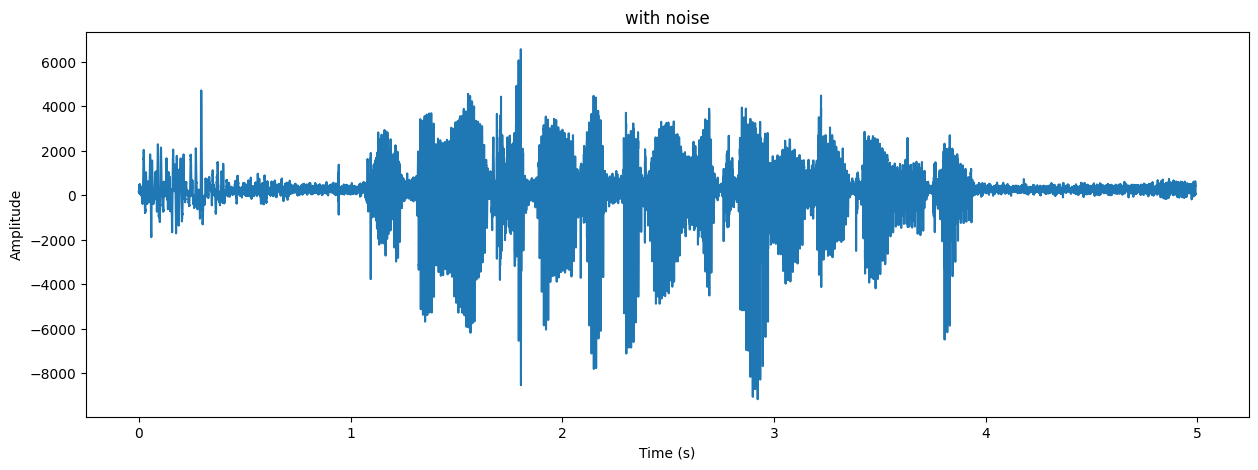

[1 1 1 ... 2 2 1]


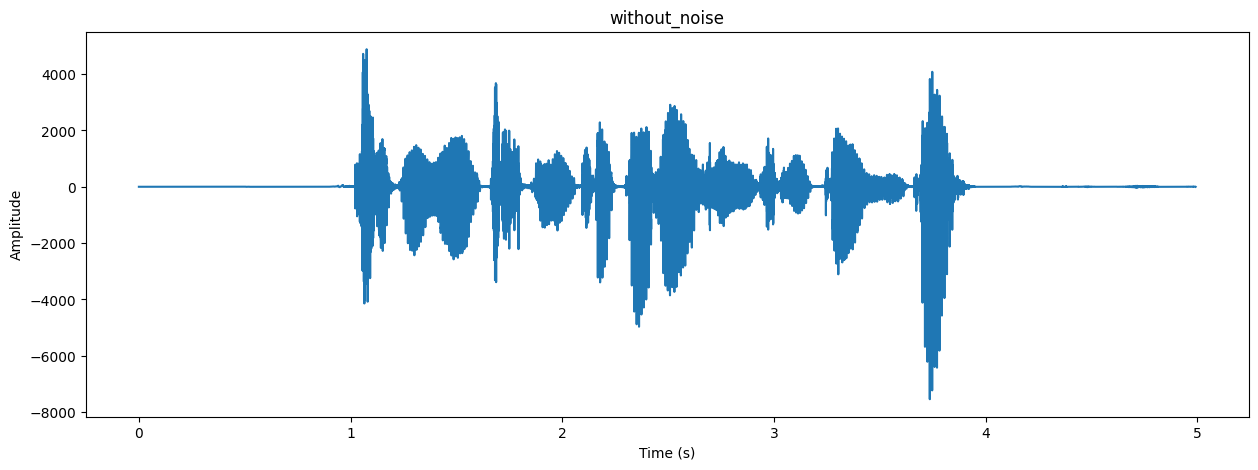

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import sys

def wav_to_wave(path):
    '''
    .wav 파일을 wave 오디오 음원으로 변환
    
    path : 오디오 경로
    '''
    wav_file = wave.open(path, 'r')
    signal = wav_file.readframes(-1)
    signal = np.frombuffer(signal, dtype=np.int16)
    sample_rate = wav_file.getframerate()
    time = np.linspace(0, len(signal) / sample_rate, num=len(signal))
    return signal, sample_rate, time


def visualize_audio(audio, sample_rate, label):
    '''
    음성파일을 그래프로 나타냄
    
    audio : .wav파일의 경로 or 넘파이 오디오 배열
    sample_rate : 넘파이 오디오 배열 입력 시 필요함, .wav 경로 입력 시 None으로 입력할 것
    label : 그래프에 표시할 레이블
    '''
    # .wav 파일의 경로를 입력했을 경우
    if sample_rate == None:
        signal, sample_rate, time = wav_to_wave(audio)
    # 넘파이 배열을 입력했을 경우
    else:
        signal = audio
        time = np.linspace(0, len(signal) / sample_rate, num=len(signal))
    
    print(signal)
    # 그래프 그리기
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()    

# Example usage
file_path_list = ['output_1.wav', 'output_2.wav']
label_list = ['with noise', 'without_noise']
for path, label in zip(file_path_list, label_list):
    visualize_audio(audio=path, sample_rate=None, label=label)

제거된 잡음을 wav와 audio 둘 다 반환 가능하도록 만들기

성공!!!

In [ ]:
'''
240620 sk 사물인식 건으로 음성인식 업무 보류.
noisereduce 라이브러리 이용해서 노이즈 감소시키는 테스트 해보려고 함.
아래 코드는 chatgpt가 마지막으로 만들어준 코드
바로 위 코드에다가 노이즈 감소 코드를 추가했고 아직 실행은 안해봄
'''

import speech_recognition as sr
import wave
import noisereduce as nr
import numpy as np

# 오디오 데이터를 wav 파일로 저장하는 함수
def save_buffer_to_wav(buffer, sample_rate, sample_width, filename):
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)  # 모노
        wf.setsampwidth(sample_width)
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(buffer))

# 마이크에서 음성을 스트리밍하는 함수
def record_audio(filename="output.wav"):
    chunk_size = 1024
    recognizer = sr.Recognizer()
    microphone = sr.Microphone(sample_rate=16000, chunk_size=chunk_size)
    buffer = []
    num_chunks = int(5 * microphone.SAMPLE_RATE / chunk_size)

    with microphone as source:
        print("Adjusting for ambient noise...")
        recognizer.adjust_for_ambient_noise(source)  # 주변 소음을 기준으로 에너지 임계값 조정

        print("Recording...")
        recognizer.energy_threshold += 100

        while len(buffer) < num_chunks:
            buffer.append(source.stream.read(chunk_size))

    # 버퍼를 하나의 오디오 데이터로 결합
    audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
    # 노이즈 감소
    reduced_noise = nr.reduce_noise(y=audio_data,
                                    sr=microphone.SAMPLE_RATE,
                                    prop_decrease=0.0)
    '''
    [reduce_noise 기본값 및 인수 설명]
    y=, # 입력 신호 (numpy 배열 형태).
    sr=, # 입력 신호의 샘플링 레이트.
    stationary=False, # 정적 노이즈 감소를 수행할지 여부 (기본값: False).
    y_noise=None, # 노이즈 신호 (정적 노이즈 감소 시 통계 계산용).
    prop_decrease=1.0, # 노이즈 감소 비율 (기본값: 1.0, 100%).
    time_constant_s=2.0, # 비정적 노이즈 감소 시 노이즈 플로어 계산 시간 상수 (초 단위, 기본값: 2.0).
    freq_mask_smooth_hz=500, # 마스크를 주파수 범위에서 평활화 (Hz 단위, 기본값: 500).
    time_mask_smooth_ms=50, # 마스크를 시간 범위에서 평활화 (밀리초 단위, 기본값: 50).
    thresh_n_mult_nonstationary=2, # 비정적 노이즈 감소 시 임계값 배수 (기본값: 2).
    sigmoid_slope_nonstationary=10, # 비정적 노이즈 감소 시 시그모이드 기울기 (기본값: 10).
    n_std_thresh_stationary=1.5, # 정적 노이즈 감소 시 평균 위의 표준 편차 수 (기본값: 1.5).
    tmp_folder=None, # 병렬 처리 시 임시 폴더 (기본값: None).
    chunk_size=600000, # 신호 청크 크기 (기본값: 600000).
    padding=30000, # 각 신호 청크를 패딩하는 크기 (기본값: 30000).
    n_fft=1024, # FFT 윈도우 길이 (기본값: 1024).
    win_length=None, # 윈도우 길이 (기본값: n_fft와 동일).
    hop_length=None, # 인접 STFT 열 간의 오디오 샘플 수 (기본값: win_length // 4).
    clip_noise_stationary=True, # 정적 노이즈 감소 시 노이즈 클립 여부 (기본값: True).
    use_tqdm=False, # 진행률 표시줄 표시 여부 (기본값: False).
    n_jobs=1, # 병렬 작업 수 (기본값: 1).
    use_torch=False, # 토치 버전의 스펙트럼 게이팅 사용 여부 (기본값: False).
    device="cuda",) # 토치 스펙트럼 게이팅을 실행할 장치 (기본값: "cuda").
    '''

    # 노이즈 감소된 데이터를 다시 버퍼로 변환
    buffer = [reduced_noise.tobytes()]

    sample_rate = microphone.SAMPLE_RATE
    sample_width = microphone.SAMPLE_WIDTH
    save_buffer_to_wav(buffer, sample_rate, sample_width, filename)
    print("Audio saved to {}".format(filename))
    return np.frombuffer(buffer[0], dtype=np.int16), sample_rate

buffer, sample_rate = record_audio()

Adjusting for ambient noise...
Recording...
Audio saved to output.wav


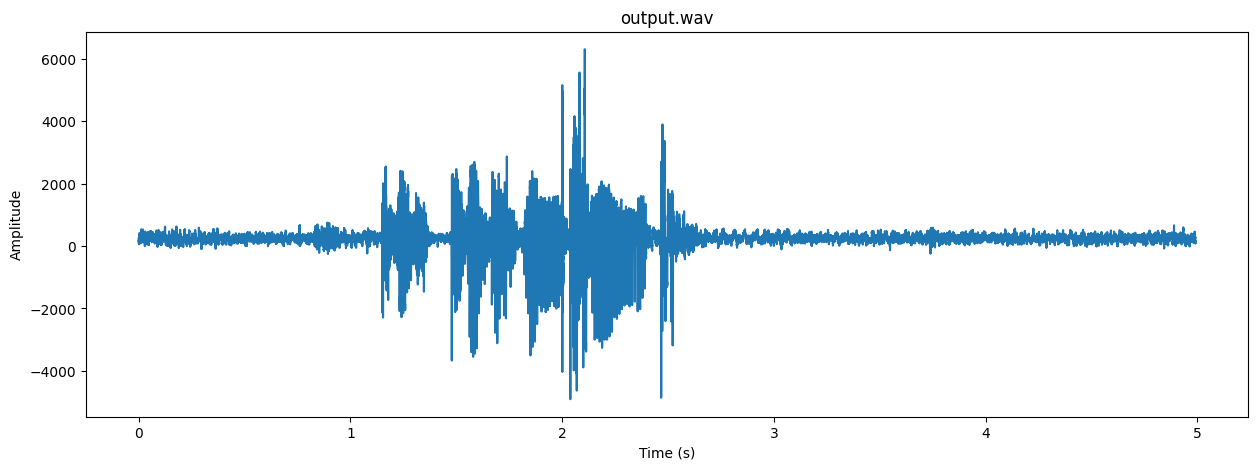

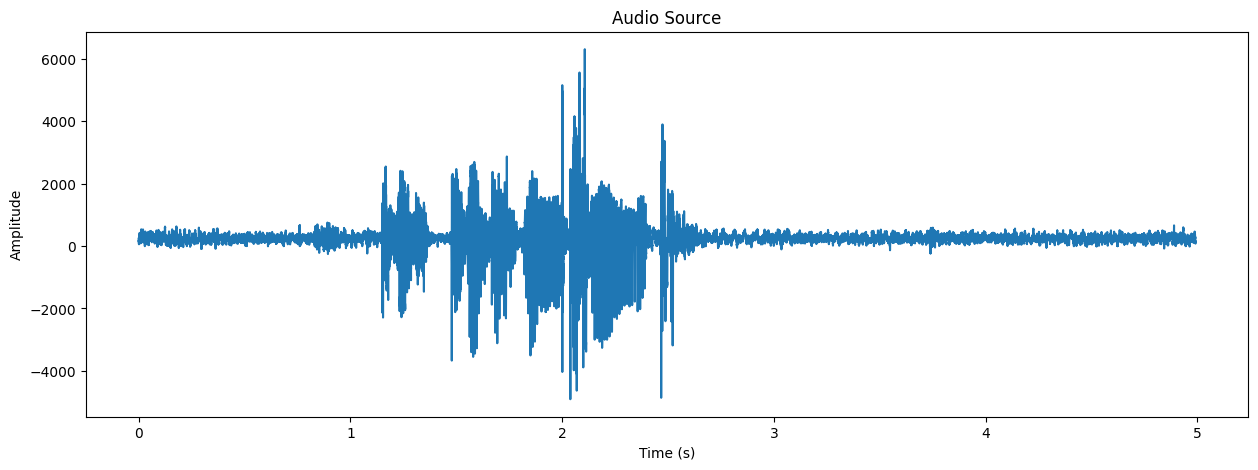

In [ ]:
# 두개 그려보기
visualize_audio(audio='output.wav', sample_rate=None, label='output.wav')
visualize_audio(audio=buffer, sample_rate=sample_rate, label='Audio Source')

일반 whisper 모델에 wav 말고 음성파일로 인퍼런스 해보기

-> 완전 잘됨

In [ ]:
import pyaudio
import threading
import numpy as np
import scipy.io.wavfile

class AudioSave:
    def __init__(self, path=None):
        '''
        요청 받았을 때 오디오를 스트리밍 하여 원하는 만큼 저장
        '''
        self.path = path
        self.sr = 16000
        self.chunk = int(self.sr / 10)
        self.audio = pyaudio.PyAudio()
        self.format = pyaudio.paInt16
        self.channels = 1

    def run(self):
        self.run_thread = threading.Thread(target=self._run)
        self.run_thread.start()

    def _run(self):
        '''
        run() thread
        '''
        self.stream = self.audio.open(format=self.format, channels=self.channels, rate=self.sr, input=True, frames_per_buffer=self.chunk)
        self.buffer = []
        self.streaming_status = True
        while self.streaming_status:
            one_chunk = self.stream.read(self.chunk)
            self.buffer.append(one_chunk)

    def stop(self):
        '''
        녹음 중지
        '''
        self.streaming_status = False
        self.run_thread.join()
        return self._buffer_to_numpy(self.buffer), self.sr

    def _buffer_to_numpy(self, buffer):
        audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
        audio_data = audio_data.astype(np.float32) / 32768.0  # Convert to float32
        
        # Save to output.wav
        scipy.io.wavfile.write('output.wav', self.sr, (audio_data * 32768).astype(np.int16))
        
        return audio_data
    
import whisper
import numpy as np

# Whisper 모델 로드
model = whisper.load_model("base")

# AudioSave 클래스 인스턴스 생성 및 녹음 시작
audio_save = AudioSave()
audio_save.run()

# 일정 시간 녹음 후 중지
import time
time.sleep(5)  # 5초 동안 녹음
audio_data, sr = audio_save.stop()  # numpy 배열과 샘플링 레이트 반환

# Whisper 모델을 사용하여 녹음된 오디오 데이터를 처리
result = model.transcribe(audio_data)
print('오디오 소스 입력')
print(result)
print('')
print('wav파일 입력')
result = model.transcribe('output.wav')
print(result)

오디오 소스 입력
{'text': ' 테스트의 녹음 중입니다.', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.0, 'text': ' 테스트의 녹음 중입니다.', 'tokens': [50364, 30516, 29271, 2785, 36906, 5654, 7596, 7416, 13, 50564], 'temperature': 0.0, 'avg_logprob': -0.6549389579079368, 'compression_ratio': 0.75, 'no_speech_prob': 0.04318860545754433}], 'language': 'ko'}

wav파일 입력
{'text': ' 테스트의 녹음 중입니다.', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.0, 'text': ' 테스트의 녹음 중입니다.', 'tokens': [50364, 30516, 29271, 2785, 36906, 5654, 7596, 7416, 13, 50564], 'temperature': 0.0, 'avg_logprob': -0.6549389579079368, 'compression_ratio': 0.75, 'no_speech_prob': 0.04318860545754433}], 'language': 'ko'}


faster whisper에도 wav 말고 오디오 소스 넣어보기

-> 동일하게 완전 잘 됨. faster whisper의 데이터 입력 처리가 whisper와 동일하게 되어있는 것으로 보임

In [ ]:
import os
from faster_whisper import WhisperModel # faster_whisper

class Cumtom_whisper:
    def __init__(self):
        '''
        최대 4배 빠른 faster whisper를 사용하여 cpu로 저장된 wav파일에 STT 수행
        
        model_size : tiny, tiny.en, base, base.en, small, small.en, medium, medium.en, large-v1, large-v2, large-v3, or large
        '''
        # 환경 설정(Window 아나콘다 환경에서 아래 코드 실행 안하면 에러남)
        try: os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "true"
        except Exception as e: print(f'os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "true" 실행해서 발생한 에러. 하지만 무시하고 진행: {e}')

        try: os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
        except Exception as e: print(f'os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 실행해서 발생한 에러. 하지만 무시하고 진행: {e}')

    def set_model(self, model_name):
        '''
        model_size : tiny, tiny.en, base, base.en, small, small.en, medium, medium.en, large-v1, large-v2, large-v3, or large
        '''
        self.model = WhisperModel(model_name, device="cpu", compute_type="int8")
        print(f'STT 모델 변경: {model_name}')

    def run(self, audio, language=None):
        '''
        저장된 tmp.wav를 불러와서 STT 추론 수행

        audio : wav파일의 경로 or numpy로 변환된 오디오 파일 소스
        language : ko, en 등 언어 선택 가능. 선택하지 않으면 언어 분류 모델 내부적으로 수행함
        '''
        start = time.time()
        # 추론

        segments, info = self.model.transcribe(audio, beam_size=5, word_timestamps=True, language=language)
        # 결과 후처리
        dic_list = []
        for segment in segments:
            if segment.no_speech_prob > 0.6: continue # 말을 안했을 확률이 크다고 감지되면 무시
            for word in segment.words:
                _word = word.word
                _start = round(word.start, 2)
                _end = round(word.end, 2)
                dic_list.append([_word, _start, _end])
        # 시간 계산
        self.spent_time = round(time.time()-start, 2)
        
        # 텍스트 추출
        result_txt = self._make_txt(dic_list)
        return dic_list, result_txt

    def _make_txt(self, dic_list):
        '''
        [word, start, end]에서 word만 추출하여 txt로 반환
        '''
        result_txt = ''
        for dic in dic_list:
            txt = dic[0]
            result_txt = f'{result_txt}{txt}'
        return result_txt
    
custom_model = Cumtom_whisper()
custom_model.set_model('base')

# AudioSave 클래스 인스턴스 생성 및 녹음 시작
audio_save = AudioSave()
audio_save.run()

# 일정 시간 녹음 후 중지
import time
time.sleep(5)  # 5초 동안 녹음
audio_data, sr = audio_save.stop()  # numpy 배열과 샘플링 레이트 반환

# Whisper 모델을 사용하여 녹음된 오디오 데이터를 처리
dic_list, result_txt = custom_model.run(audio_data)
print('오디오 소스 입력')
print(result_txt)
print('')
print('wav파일 입력')
dic_list, result_txt = custom_model.run('output.wav')
print(result_txt)

STT 모델 변경: base
오디오 소스 입력
 현재 녹음 테스트를 하고 있습니다.

wav파일 입력
 현재 녹음 테스트를 하고 있습니다.


### 모듈 제작

[프로세스 진행 순서]
1. 음원 듣기
2. 디노이즈 실행
3. 일반 음성, 디노이즈 음성 모델 투입
4. 추론 결과 별도 표시

[핵심 기능]
1. 모델 추론은 오디오 소스, wav 저장은 별도로(확인 용도)
2. 디노이즈 정도 조절 가능하게끔(조절 bar 사용)
3. 추론 결과 창 별도 표시 필요(순차적으로 처리해도 상관 없음. 인퍼런스 시간만 표시되면 됨)

In [ ]:
# 모듈 제작 참고용 코드(아래 셀에서 모듈 제작)

import speech_recognition as sr
import wave
import noisereduce as nr
import numpy as np

# 오디오 데이터를 wav 파일로 저장하는 함수
def save_buffer_to_wav(buffer, sample_rate, sample_width, filename):
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)  # 모노
        wf.setsampwidth(sample_width)
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(buffer))

# 마이크에서 음성을 스트리밍하는 함수
def record_audio(filename="output.wav"):
    chunk_size = 1024
    recognizer = sr.Recognizer()
    microphone = sr.Microphone(sample_rate=16000, chunk_size=chunk_size)
    buffer = []
    num_chunks = int(5 * microphone.SAMPLE_RATE / chunk_size)

    with microphone as source:
        print("Adjusting for ambient noise...")
        recognizer.adjust_for_ambient_noise(source)  # 주변 소음을 기준으로 에너지 임계값 조정

        print("Recording...")
        recognizer.energy_threshold += 100

        while len(buffer) < num_chunks:
            buffer.append(source.stream.read(chunk_size))

    # 버퍼를 하나의 오디오 데이터로 결합
    audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
    # 노이즈 감소
    reduced_noise = nr.reduce_noise(y=audio_data, sr=microphone.SAMPLE_RATE, prop_decrease=0.0)
    # 노이즈 감소된 데이터를 다시 버퍼로 변환
    buffer = [reduced_noise.tobytes()]

    sample_rate = microphone.SAMPLE_RATE
    sample_width = microphone.SAMPLE_WIDTH
    save_buffer_to_wav(buffer, sample_rate, sample_width, filename)
    print("Audio saved to {}".format(filename))

    # 반환할 오디오 소스 만들기
    audio = buffer_to_numpy(buffer, sample_rate)
    return audio, sample_rate

import scipy.io.wavfile
def buffer_to_numpy(buffer, sample_rate):
    audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
    audio_data = audio_data.astype(np.float32) / 32768.0  # Convert to float32
    
    # Save to output.wav
    scipy.io.wavfile.write('output.wav', sample_rate, (audio_data * 32768).astype(np.int16))
    
    return audio_data


import whisper
import numpy as np

# Whisper 모델 로드
model = whisper.load_model("base")

audio, sample_rate = record_audio()

# Whisper 모델을 사용하여 녹음된 오디오 데이터를 처리
result = model.transcribe(audio)
print('오디오 소스 입력')
print(result)
print('')
print('wav파일 입력')
result = model.transcribe('output.wav')
print(result)

Adjusting for ambient noise...
Recording...
Audio saved to output.wav
오디오 소스 입력
{'text': ' 누군 테스트를 진행하고 있습니다.', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.0, 'text': ' 누군 테스트를 진행하고 있습니다.', 'tokens': [50364, 15647, 24707, 30516, 48404, 2429, 32544, 7040, 10552, 13, 50564], 'temperature': 0.0, 'avg_logprob': -0.557754397392273, 'compression_ratio': 0.8070175438596491, 'no_speech_prob': 0.02545975148677826}], 'language': 'ko'}

wav파일 입력
{'text': ' 누군 테스트를 진행하고 있습니다.', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.0, 'text': ' 누군 테스트를 진행하고 있습니다.', 'tokens': [50364, 15647, 24707, 30516, 48404, 2429, 32544, 7040, 10552, 13, 50564], 'temperature': 0.0, 'avg_logprob': -0.557754397392273, 'compression_ratio': 0.8070175438596491, 'no_speech_prob': 0.02545975148677826}], 'language': 'ko'}


In [ ]:
# 기본 
import os
import threading
import time
import wave
import tkinter as tk
from tkinter import messagebox
from tkinter import filedialog

# 추가
from faster_whisper import WhisperModel # faster_whisper
import speech_recognition as sr
import noisereduce as nr
import numpy as np
import scipy.io.wavfile

class Audio_record:
    def __init__(self):
        '''
        요청 받았을 때 오디오를 스트리밍 하여 원하는 만큼 녹음하여 디노이즈
        '''
        # 기본 선언
        self.chunk_size = 100
        self.recognizer = sr.Recognizer()
        self.microphone = sr.Microphone(sample_rate=16000, chunk_size=self.chunk_size)
        self.buffer = []
        self.recording = False
        
        # 주변 소음 조정
        self.adjust_noise()

        print('Audio_record 초기화 성공')
        

    def adjust_noise(self):
        '''
        주변 소음 조정
        '''
        with self.microphone as source:
            print('주변 소음에 맞게 조정 중...')
            self.recognizer.adjust_for_ambient_noise(source)
            self.recognizer.energy_threshold += 100

    def record_start(self):
        '''녹음이 시작되는 함수'''
        if self.recording == False:
            self.record_thread = threading.Thread(target=self._record_start)
            self.record_thread.start()
    
    def _record_start(self):
        self.recording = True
        self.buffer = []
        with self.microphone as source:
            while self.recording:
                self.buffer.append(source.stream.read(self.chunk_size))
        
    def record_stop(self, denoise_value):
        '''녹음이 종료되고 디노이징 과정을 거치는 함수'''
        # thread 종료하고, 끝날 때 까지 join으로 대기
        self.recording = False
        self.record_thread.join()
        # 버퍼를 하나의 오디오 데이터로 결합
        audio_data = np.frombuffer(b''.join(self.buffer), dtype=np.int16)
        sample_rate = self.microphone.SAMPLE_RATE
        return self._denoise_process(audio_data, sample_rate, denoise_value)

    
    def load_wav(self, path, denoise_value):
        '''wav파일을 불러와 디노이징 과정을 거치는 함수'''
        buffer = []
        with wave.open(path, 'rb') as wf:
            chunk_size = self.chunk_size
            data = wf.readframes(chunk_size)
            while data:
                buffer.append(data)
                data = wf.readframes(chunk_size)

        audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
        sample_rate = wf.getframerate()
        return self._denoise_process(audio_data, sample_rate, denoise_value)

    
    def _denoise_process(self, audio_data, sample_rate, denoise_value):
        '''
        오디오를 받아 디노이징을 적용하고, 원본과 디노이즈값둘 둘 다 저장하고 반환한다.
        
        audio_data : int16 np 형식 오디오 데이터. chunk를 append하여 만들어진 buffer를 다음과 같이 처리한 예시) np.frombuffer(b''.join(self.buffer), dtype=np.int16)
        sample_rate : 샘플 레이트 입력
        denoise_value : 디노이즈 적용값 설정
        
        return: {'audio_denoise': audio_denoise, 'audio_noise': audio_noise, 'sample_rate': sample_rate}
        '''
        # 1. 노이즈 감소 처리
        denoise = nr.reduce_noise(y=audio_data, sr=sample_rate, prop_decrease=denoise_value)
        buffer_denoise = [denoise.tobytes()] # 데이터를 다시 버퍼로 변환
        # 2. 노이즈 감소 없이
        noise = nr.reduce_noise(y=audio_data, sr=sample_rate, prop_decrease=0.0)
        buffer_noise = [noise.tobytes()] # 데이터를 다시 버퍼로 변환
        
        # 1. 노이즈 감소 파일 저장
        self._save_buffer_to_wav(buffer_denoise, self.microphone.SAMPLE_RATE, self.microphone.SAMPLE_WIDTH, 'input_denoise.wav')
        # 2. 노이즈 감소 없는 파일 저장
        self._save_buffer_to_wav(buffer_noise, self.microphone.SAMPLE_RATE, self.microphone.SAMPLE_WIDTH, 'input_noise.wav')
        
        # 오디오 소스 파일로 return
        audio_denoise = self._buffer_to_numpy(buffer_denoise, self.microphone.SAMPLE_RATE)
        audio_noise = self._buffer_to_numpy(buffer_noise, self.microphone.SAMPLE_RATE)

        return {'audio_denoise':audio_denoise, 'audio_noise':audio_noise, 'sample_rate':self.microphone.SAMPLE_RATE}


    def _buffer_to_numpy(self, buffer, sample_rate):
        '''buffer를 입력하면 whisper에서 추론 가능한 입력 형태의 오디오로 반환'''
        audio_data = np.frombuffer(b''.join(buffer), dtype=np.int16)
        audio_data = audio_data.astype(np.float32) / 32768.0  # Convert to float32        
        return audio_data
        

    def _save_buffer_to_wav(self, buffer, sample_rate, sample_width, filename):
        with wave.open(filename, 'wb') as wf:
            wf.setnchannels(1)  # 모노
            wf.setsampwidth(sample_width)
            wf.setframerate(sample_rate)
            wf.writeframes(b''.join(buffer))
        
class Cumtom_faster_whisper:
    def __init__(self):
        '''
        최대 4배 빠른 faster whisper를 사용하여 cpu로 저장된 wav파일에 STT 수행
        '''
        # 환경 설정(Window 아나콘다 환경에서 아래 코드 실행 안하면 에러남)
        try: os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "true"
        except Exception as e: print(f'os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "true" 실행해서 발생한 에러. 하지만 무시하고 진행: {e}')

        try: os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
        except Exception as e: print(f'os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 실행해서 발생한 에러. 하지만 무시하고 진행: {e}')
        print('Cumtom_faster_whisper 초기화 성공')

    def set_model(self, model_name):
        '''
        모델 설정
        '''
        model_list = ['tiny', 'tiny.en', 'base', 'base.en', 'small', 'small.en', 'medium', 'medium.en', 'large-v1', 'large-v2', 'large-v3', 'large']
        if not model_name in model_list:
            model_name = 'base'
            print('모델 이름 잘못됨. base로 설정')
        self.model = WhisperModel(model_name, device="cpu", compute_type="int8")
        return model_name

    def run(self, audio, language=None):
        '''
        저장된 tmp.wav를 불러와서 STT 추론 수행

        audio : wav파일의 경로 or numpy로 변환된 오디오 파일 소스
        language : ko, en 등 언어 선택 가능. 선택하지 않으면 언어 분류 모델 내부적으로 수행함
        '''
        start = time.time()
        # 추론

        segments, info = self.model.transcribe(audio, beam_size=5, word_timestamps=True, language=language)
        # 결과 후처리
        dic_list = []
        for segment in segments:
            if segment.no_speech_prob > 0.6: continue # 말을 안했을 확률이 크다고 감지되면 무시
            for word in segment.words:
                _word = word.word
                _start = round(word.start, 2)
                _end = round(word.end, 2)
                dic_list.append([_word, _start, _end])
        # 시간 계산
        self.spent_time = round(time.time()-start, 2)
        
        # 텍스트 추출
        result_txt = self._make_txt(dic_list)
        print(result_txt)
        return dic_list, result_txt, self.spent_time

    def _make_txt(self, dic_list):
        '''
        [word, start, end]에서 word만 추출하여 txt로 반환
        '''
        result_txt = ''
        for dic in dic_list:
            txt = dic[0]
            result_txt = f'{result_txt}{txt}'
        return result_txt

class Gui:
    def __init__(self):
        '''
        GUI로 다양한 버튼 인터페이스 구성
        '''
        self.running = True # 모든 multi thread를 정지시키기 위한 플래그
        self.model_name = 'base'

        # model, 음성 녹음 관련 초기화
        self.audio_record = Audio_record()
        self.model = Cumtom_faster_whisper()
        self.model.set_model(self.model_name)

        # gui 관련 초기화
        self._init_gui()
        

    def _start_record(self):
        '''녹음 시작'''
        self.audio_record.record_start()

    def _stop_record(self):
        '''녹음 중지'''
        self.audio_dic = self.audio_record.record_stop(self.denoise_slider.get())

    def _load_wav(self):
        '''음성파일 불러오기'''
        filename = filedialog.askopenfilename()
        self.audio_dic = self.audio_record.load_wav(filename, self.denoise_slider.get())

    def _model_set(self):
        '''모델 적용'''
        # 텍스트 박스에서 사용자가 입력한 모델 이름 취득
        model_name = self.text_box_model_name.get('1.0', tk.END).strip()
        # 모델 적용 후 필터링된 모델 이름 취득
        model_name = self.model.set_model(model_name)
        # 필터링된 모델 이름 텍스트 박스에 다시 적용
        self.text_box_model_name.delete('1.0', tk.END)
        self.text_box_model_name.insert(tk.END, model_name)

    def _model_run(self):
        '''stt 모델 추론'''
        # 모델 추론
        _, result_denoise, time_denoise = self.model.run(self.audio_dic['audio_denoise'])
        _, result_noise, time_noise = self.model.run(self.audio_dic['audio_noise'])
        # 텍스트 구성
        txt_denoise = f'{result_denoise} ({time_denoise}s)'
        txt_noise = f'{result_noise} ({time_noise}s)'

        # 텍스트 박스 출력
        self._txtbox_insert(self.text_box_denoise, txt_denoise)
        self._txtbox_insert(self.text_box_normal, txt_noise)

    def _txtbox_insert(self, txt_box, txt):
        txt_box.insert(tk.END, f'>> {txt}\n')

    def _reset_output(self):
        self.text_box_normal.delete('1.0', tk.END)
        self.text_box_denoise.delete('1.0', tk.END)

    def _reset_ambient_noise(self):
        '''주변 소음 감소'''
        self.audio_record.adjust_noise()

    def _on_closing(self):
        self.running = False
        print('프로그램이 종료됩니다')
        self.root.destroy()

    def _init_gui(self):
        '''
        GUI로 다양한 버튼 인터페이스 구성
        '''
        # 메인 윈도우 설정
        self.root = tk.Tk()
        self.root.title('STT Model v2.0.0')
        self.root.protocol('WM_DELETE_WINDOW', self._on_closing) # 창 종료 관련

        # 버튼 생성
        # 녹음 시작 & 녹음 중지 & 음성 로드 & 모델 적용 버튼
        frame_small = tk.Frame(self.root, pady=20)
        frame_small.pack(fill=tk.X)
        btn_start = tk.Button(frame_small, text="녹음 시작", width=20, command=self._start_record)
        btn_start.pack(side=tk.LEFT, padx=10)
        btn_stop = tk.Button(frame_small, text="녹음 중지", width=20, command=self._stop_record)
        btn_stop.pack(side=tk.LEFT, padx=10)
        btn_load = tk.Button(frame_small, text="음성 로드", width=20, command=self._load_wav)
        btn_load.pack(side=tk.LEFT, padx=10)
        btn_set_model = tk.Button(frame_small, text="모델 적용", width=20, command=self._model_set)
        btn_set_model.pack(side=tk.LEFT, padx=10)

        # 모델 이름 텍스트창
        self.label_model_name = tk.Label(frame_small, text='모델 이름')
        self.label_model_name.pack(side=tk.LEFT, padx=10)
        self.text_box_model_name = tk.Text(frame_small, height=1, width=20)
        self.text_box_model_name.pack(side=tk.LEFT, padx=10)
        self.text_box_model_name.insert(tk.END, self.model_name) # 기본 모델 설정

        # 디노이즈 조절바
        frame_denoise = tk.Frame(self.root, pady=10)
        frame_denoise.pack(fill=tk.X)
        self.label_slide_bar = tk.Label(frame_denoise, text='노이즈 감소 정도 조절 (0 ~ 1)')
        self.label_slide_bar.pack(side=tk.TOP)  # 레이블을 슬라이더 위에 배치
        self.denoise_slider = tk.Scale(frame_denoise, from_=0.0, to=1.0, resolution=0.05, orient=tk.HORIZONTAL, length=300)
        self.denoise_slider.set(1.0)
        self.denoise_slider.pack(side=tk.LEFT, fill=tk.X, expand=True)

        # 추론 버튼 & 출력창 리셋 & 주변 소음 조절 초기화 버튼
        frame_middle = tk.Frame(self.root, pady=20)
        frame_middle.pack(fill=tk.X)
        btn_process = tk.Button(frame_middle, text="STT 모델 추론", width=40, command=self._model_run)
        btn_process.pack(side=tk.LEFT, padx=10)
        btn_output_reset = tk.Button(frame_middle, text="출력창 리셋", width=40, command=self._reset_output)
        btn_output_reset.pack(side=tk.LEFT, padx=10)
        btn_ambient = tk.Button(frame_middle, text="주변 소음 조절 초기화", width=40, command=self._reset_ambient_noise)
        btn_ambient.pack(side=tk.LEFT, padx=10)
        
        # 아래 커다란 출력 창 2개
        self.label_normal = tk.Label(self.root, text='원본 음성 추론 결과')
        self.label_normal.pack()
        self.text_box_normal = tk.Text(self.root, height=15, width=120)
        self.text_box_normal.pack(pady=10)
        self.label_denoise = tk.Label(self.root, text='디노이즈 음성 추론 결과')
        self.label_denoise.pack()
        self.text_box_denoise = tk.Text(self.root, height=15, width=120)
        self.text_box_denoise.pack(pady=10)

        # gui 루프 시작
        self.root.mainloop()

gui = Gui()

주변 소음에 맞게 조정 중...
Audio_record 초기화 성공
Cumtom_faster_whisper 초기화 성공
 테스트 진행하겠습니다.
 테스트 진행하겠습니다.
주변 소음에 맞게 조정 중...
주변 소음에 맞게 조정 중...
주변 소음에 맞게 조정 중...
주변 소음에 맞게 조정 중...
 노이즈가 발생하는 상대에서의 데스틱 키 성능
 노이즈가 발생하는 상태에서의 스틱티 성능
주변 소음에 맞게 조정 중...
 지금 지능의 지능을 차는 것이 좋지, 끝난 것이 좋지, 확인하고 있습니다.
 지금 기능을 켜는 것이 좋을지 끊은 것이 좋을지 확인하고 있습니다.
주변 소음에 맞게 조정 중...
 디노이지를 적용했을 때 성능 테스트는 변함이 없습니다.
 디노이지를 적용했을 때 성능 테스트는 변함이 없습니다.
 T 노이저를 적용했을 때요 이 성능 테스트
 뒤노이지를 적용했을 때 이 성능 테스트
 목 마린데 물을 좀 따가주세요.
 목마른데 물을 좀 떠다주세요
 목마른데 물을 좀 더 넣어주세요
 목 마른데 물을 좀 더 넣어주세요
프로그램이 종료됩니다


cer 계산 로직
https://github.com/hyeonsangjeon/computing-Korean-STT-error-rates